# Kuzushiji Classification with fastai

In [1]:
%matplotlib inline
from fastai.vision import *
from tqdm import tqdm_notebook as tqdm
import stable.utils

In [2]:
stable.utils.group_valid_split()

In [3]:
path = Path("data")
train_fnames = (path/"train_fnames.txt").read_text().split("\n")
valid_fnames = (path/"valid_fnames.txt").read_text().split("\n")
df_train = pd.read_csv(path/"train.csv")
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('data/unicode_translation.csv').values}

## Create training data (512x512 pixel context around center point)

Instead of predicting the size of characters like in K_mat's kernel, we just train the classifier to deal with 512x512
pixel area. This skips regressing bounding box coordinates.

In [4]:
#!rm -r data/train_images_chars_256/

In [5]:
def create_classification_train_data(path, df_train, train_fnames, valid_fnames, bg_class=True, n_bg_examples_per_page=20):
    # Was error with char_is_valid, hopefully fixed now
    char_fnames = []
    char_labels = []
    char_is_valid = []

    save_path = path/"train_images_chars_512"

    if not save_path.exists():
        save_path.mkdir()

    R = 256  # 512 // 2

    for _, row in tqdm(df_train.iterrows()):
        im = np.array(PIL.Image.open(path/"train_images"/(row.image_id+".jpg")))
        labels = row.labels
        if type(labels) == float and math.isnan(labels):
            # No characters in this page
            if bg_class == True:
                # Create negative examples
                height, width = im.shape[:2]
                x_centers = np.random.randint(R, width - R, size=n_bg_examples_per_page)
                y_centers = np.random.randint(R, height - R, size=n_bg_examples_per_page)
                for i in range(n_bg_examples_per_page):
                    x0, y0, x1, y1 = x_centers[i] - R, y_centers[i] - R, x_centers[i] + R, y_centers[i] + R
                    im_char = PIL.Image.fromarray(im[y0:y1, x0:x1])
                    fname = row.image_id + "_" + str(i).zfill(4) + ".jpg"
                    char_fnames.append(fname)
                    char_labels.append("BACKGROUND")
                    im_char.save(save_path/fname)
                    if row.image_id in train_fnames:
                        char_is_valid.append(False)
                    else:
                        char_is_valid.append(True)
        else:
            labels_split = labels.split(" ")
            classes = [labels_split[i] for i in range(0, len(labels_split), 5)]
            bboxes = [list(map(int, labels_split[i+1:i+5])) for i in range(0, len(labels_split), 5)]

            for i in range(len(classes)):
                label = classes[i]
                x, y, width, height = bboxes[i]
                center_x = x + width // 2
                center_y = y + height // 2
                x0, y0 = max(0, center_x - R), max(0, center_y - R)
                x1, y1 = center_x + R, center_y + R
                im_char = PIL.Image.fromarray(im[y0:y1, x0:x1])
                fname = row.image_id + "_" + str(i).zfill(4) + ".jpg"
                char_fnames.append(fname)
                char_labels.append(label)
                im_char.save(save_path/fname)
                if row.image_id in train_fnames:
                    char_is_valid.append(False)
                else:
                    char_is_valid.append(True)
                    
    chars_df = pd.DataFrame(np.array([char_fnames, char_labels]).transpose(), columns=["filename", "label"])
    chars_df["is_valid"] = char_is_valid
    chars_df.to_csv(path/"train_chars_512.csv", index=False)

In [9]:
create_classification_train_data(path, df_train, train_fnames, valid_fnames, bg_class=True)

## Train resnet classifier

In [4]:
chars_df = pd.read_csv(path/"train_chars_512.csv")

In [6]:
data = (ImageList.from_df(chars_df, path/"train_images_chars_512")
        .split_from_df("is_valid")
        .label_from_df("label", classes=list(set(chars_df["label"])))
        .transform(get_transforms(do_flip=False), size=(256,256))
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )

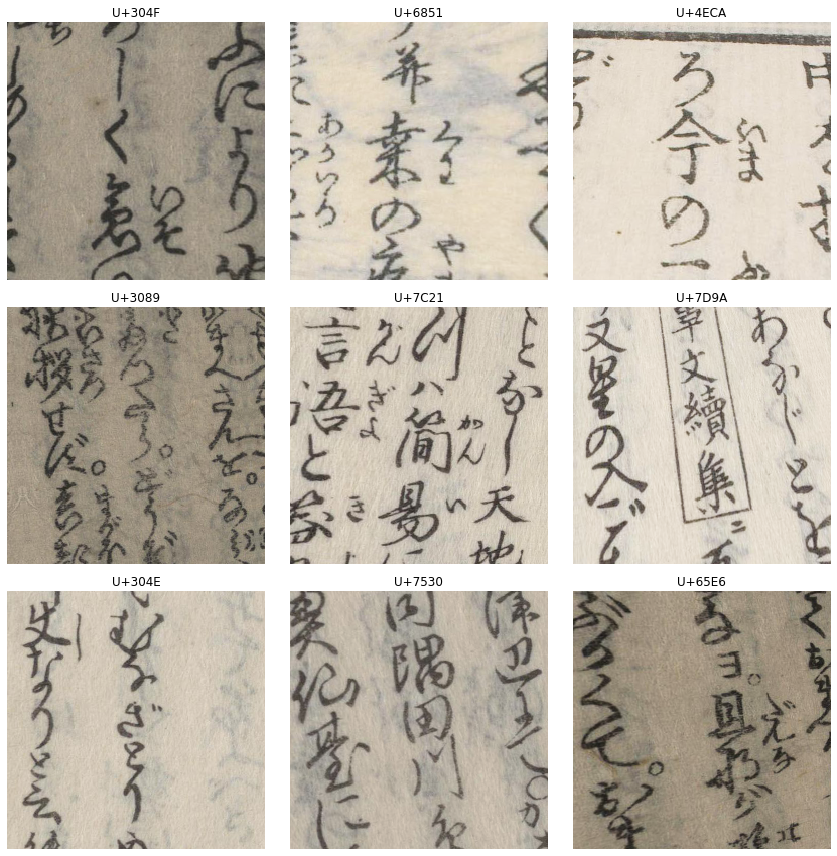

In [7]:
data.show_batch(3)

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy],
                    callback_fns=[#callbacks.ReduceLROnPlateauCallback,
                                  ShowGraph
                                 ]).mixup().to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


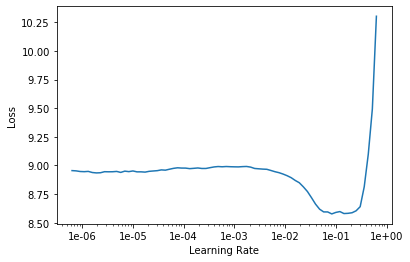

In [9]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.868447,2.573695,0.529231,29:16
1,3.704574,2.219960,0.602255,29:14
2,3.455877,2.006405,0.647203,29:13
3,3.314727,1.814789,0.688650,29:13
4,3.192253,1.750766,0.706467,29:15


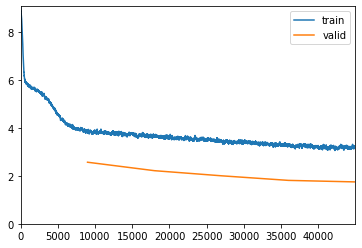

In [10]:
learn.fit_one_cycle(5, slice(1e-2))

In [13]:
learn.unfreeze()

In [11]:
learn.save("5epochs")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


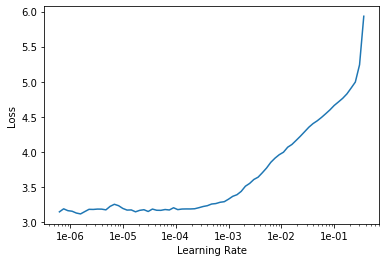

In [14]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.931406,1.439572,0.766816,36:50
1,2.579988,1.242450,0.806084,36:48
2,2.419372,1.007952,0.834107,36:47
3,2.285443,0.895375,0.858856,36:47
4,2.203946,0.784991,0.873710,36:50
5,2.006298,0.696099,0.893573,36:48
6,1.940827,0.635070,0.903937,36:48
7,1.779418,0.608330,0.910826,37:02
8,1.821874,0.601266,0.915280,36:51
9,1.736426,0.608769,0.914910,37:04


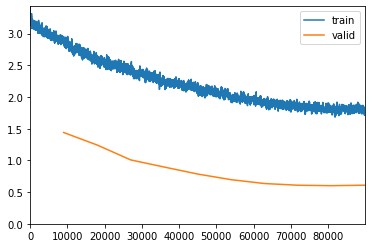

In [15]:
learn.fit_one_cycle(10, slice(1e-3))

In [16]:
learn.save("15epochs")

epoch,train_loss,valid_loss,accuracy,time
0,1.794176,0.615253,0.908533,36:49
1,1.902431,0.658813,0.896846,36:51
2,1.899683,0.647860,0.893900,36:52
3,1.893751,0.633064,0.899765,36:51
4,1.832594,0.573015,0.911047,36:52
5,1.760845,0.558796,0.913366,36:53
6,1.707952,0.524650,0.920837,36:52
7,1.609017,0.499223,0.927179,36:52
8,1.595477,0.505071,0.928873,36:50
9,1.544197,0.510837,0.928229,36:49


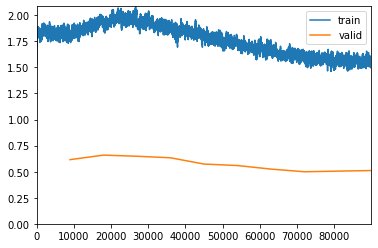

In [17]:
learn.fit_one_cycle(10, slice(1e-3))

In [18]:
learn.save("25epochs")

epoch,train_loss,valid_loss,accuracy,time
0,1.549091,0.512135,0.926191,36:49
1,1.733540,0.531714,0.917785,36:47
2,1.700394,0.586823,0.907448,36:47
3,1.696572,0.556833,0.913040,36:47
4,1.615809,0.532649,0.919788,36:47
5,1.555760,0.513806,0.922619,36:48
6,1.490433,0.483184,0.927453,36:48
7,1.468418,0.471753,0.930593,36:49
8,1.418879,0.467669,0.934244,36:49
9,1.417294,0.477895,0.933768,36:46


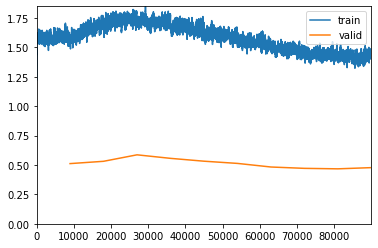

In [19]:
learn.fit_one_cycle(10, slice(1e-3))

In [20]:
learn.save("35epochs")

epoch,train_loss,valid_loss,accuracy,time
0,1.462760,0.485518,0.933274,36:47
1,1.453406,0.477960,0.931845,36:48
2,1.476979,0.481250,0.928476,36:48
3,1.462462,0.468634,0.930293,36:49
4,1.452536,0.464007,0.932083,36:46
5,1.405254,0.461458,0.931907,36:46
6,1.380449,0.457744,0.934800,36:47
7,1.377835,0.460123,0.935426,36:45
8,1.382958,0.456579,0.937869,36:49
9,1.364307,0.462871,0.937411,36:49


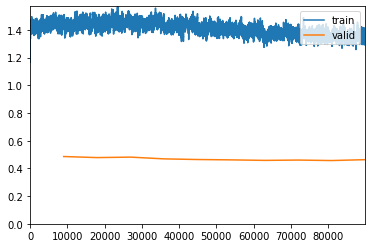

In [21]:
learn.fit_one_cycle(10, slice(3e-4))

In [22]:
learn.save("45epochs")

In [23]:
learn.export("20190930_valid_45epochs")